# Techniques for Unbalanced datasets
(by Mario Martin)

In [3]:
from sklearn import datasets
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold,
    cross_val_score
) 
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    f1_score,
    fbeta_score,
    make_scorer
)
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as cv 
import sklearn.neighbors as nb        
import numpy as np

rng = np.random.RandomState(0)

X, y = datasets.make_classification(
    n_classes = 2, 
    class_sep = 0.1, 
    weights = [0.9, 0.1],
    n_informative = 3, 
    n_redundant = 0, 
    flip_y = 0,
    n_features = 5, 
    n_clusters_per_class = 2,
    n_samples = 5000, 
    random_state = 10
)

# Let's separate data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.5)

# Proportion of examples in the smaller class (class 1) is the following
percent_smaller_class = 100 * np.sum(y == 1)/(np.sum(y == 0) + np.sum(y == 1))

print(f"Percentage of examples of the smaller class (class 1): {percent_smaller_class:.2f}%")

Percentage of examples of the smaller class (class 1): 10.00%


In [5]:
# Let's optimize k-nn for this dataset

# Maximizing Accuracy
params = {
    "n_neighbors": list(range(1,30,2)), 
    "weights": ('uniform', 'distance')
}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(
    knc, 
    param_grid = params, 
    cv = 10,  # OBS: If cv is integer, by default is Stratifyed 
    n_jobs = -1
)
clf.fit(X_train, y_train)
print(f"Best Params = {clf.best_params_}\nAccuracy on 10-fold cross-validation = {clf.best_score_}")

parval = clf.best_params_
knc = nb.KNeighborsClassifier(
    n_neighbors = parval["n_neighbors"],
    weights = parval["weights"]
)
knc.fit(X_train, y_train)
pred = knc.predict(X_test)
print(f"Accuracy on test set: {accuracy_score(y_test, pred)}")

Best Params = {'n_neighbors': 9, 'weights': 'distance'}
Accuracy on 10-fold cross-validation = 0.9168
Accuracy on test set: 0.8988


Good accuracy, but in these cases we have to observe the confusion matrix and focus not on accuracy but on recall and precision measures of the smaller class (or the f-measure that is the geometrical combination of both).


In [6]:
print(f"Confusion matrix on test set: \n{confusion_matrix(y_test, pred)}\n")
print(classification_report(y_test, pred))

Confusion matrix on test set: 
[[2220   10]
 [ 243   27]]

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2230
           1       0.73      0.10      0.18       270

    accuracy                           0.90      2500
   macro avg       0.82      0.55      0.56      2500
weighted avg       0.88      0.90      0.86      2500



Oops. f1-score of 0.18 is very low. Notice that recall for class 1 is only 0.1 (in second row of confussion matrix, we can see that we only catch 27 of 243+27 cases, that is, 0.1 of recall)... Too bad.

This effect is expected In higly unbalanced datasets. In order to improve these values, there are several techniques that can be applied.


## 1- Changing performance function

When optimizing parameters, try to focus on the optimization these measures (f-score, recall or precision) instead of optimizing accuracy.


In [7]:
# Let's optimize f1_score by creationg an scoring function "f_scorer"

# Maximizing f1_score for class 1
f_scorer = make_scorer(f1_score,pos_label=1)

params = {
    "n_neighbors": list(range(1,30,2)), 
    "weights": ('uniform','distance')
}

knc = nb.KNeighborsClassifier()
clf = GridSearchCV(
    knc, 
    param_grid = params,
    cv = 10,
    n_jobs = -1, 
    scoring = f_scorer
)
clf.fit(X_train, y_train)

print(f"Best Params= {clf.best_params_,}\nF-score on 10-fold cross-validation= {clf.best_score_}")
parval = clf.best_params_
knc = nb.KNeighborsClassifier(
    n_neighbors = parval["n_neighbors"],
    weights = parval["weights"]
)
knc.fit(X_train, y_train)

pred = knc.predict(X_test)
print(f"\nConfusion matrix on test set:\n{confusion_matrix(y_test, pred)}")
print(f"\nAccuracy on test set: {accuracy_score(y_test, pred)}")
print(classification_report(y_test, pred))

Best Params= ({'n_neighbors': 1, 'weights': 'uniform'},)
F-score on 10-fold cross-validation= 0.3753603804074593

Confusion matrix on test set:
[[2098  132]
 [ 176   94]]

Accuracy on test set: 0.8768
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2230
           1       0.42      0.35      0.38       270

    accuracy                           0.88      2500
   macro avg       0.67      0.64      0.66      2500
weighted avg       0.87      0.88      0.87      2500



Now we have f1-score for class 1 of 0.38 instead of 0.18. Nice improvement.

This method can be applied when we have parameters to adjust... but no in Naive Bayes, for instance, because it has no parameters to adjust. 


## 2- Finding good threshold function (recomended approach)

When running a classifier, instead of returning hard decisions about belonging to a class or the other, return the probability of belonging to the minority class. Probabilities can be estimated for most algorithms implemented in sklearn. Once we have the probabilities we will adjust the threshold on these probabilities to decide where belongs each element. The threshold will be set so it maximizes the f-measure. 


In [8]:
# Let's try Naive Bayes on hard decisions
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2230
           1       0.85      0.12      0.21       270

    accuracy                           0.90      2500
   macro avg       0.87      0.56      0.58      2500
weighted avg       0.90      0.90      0.87      2500



We have an f1-score of only 0.21. Let's try to impove it by selecting a good threshold for probability values. 

In [39]:
def filterp(th,ProbClass,label):
    """Given a treshold "th" and a set of probabilies of belonging
    to class label "ProbClass", return predictions.""" 
    if label==1:
        y=np.zeros(ProbClass.shape[0])
    else:
        y=np.ones(ProbClass.shape[0])
    y[ProbClass>th]=label
    return y  

def mid_tresholds(ProbTargetClass):
    tresh1 = np.sort(np.array(list(set(ProbTargetClass.tolist()))))
    tresholds_try = np.zeros((tresh1.shape[0]+1))
    tresholds_try[1:-1] = (tresh1[1:] + tresh1[0:-1])/2
    tresholds_try[-1]=1
    return tresholds_try


def best_treshold(clf,X,y,label=0):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    lth=[]
    for train_index, test_index in kf.split(X, y):
        X_train2, X_test2 = X[train_index], X[test_index]
        y_train2, y_test2 = y[train_index], y[test_index]
        clf.fit(X_train2, y_train2)
        # Obtaining probablity predictions for test data of the iterarion
        probs = clf.predict_proba(X_test2)
        # Collect probabilities of belonging to class 1
        ProbTargetClass = probs[:,label]
        # Sort probabilities and generate pairs (threshold, f1-for-that-threshold) 
        res = np.array([[th,f1_score(y_test2,filterp(th,ProbTargetClass,label),pos_label=label)] for th in mid_tresholds(ProbTargetClass)])

        # Uncomment the following lines if you want to plot at each iteration how f1-score evolves increasing the threshold 
        #plt.plot(res[:,0],res[:,1])
        #plt.show()

        # Find the threshold that has maximum value of f1-score
        maxF = np.max(res[:,1])
        optimal_th = res[res[:,1]==maxF,0]
        
        # Store the optimal threshold found for the current iteration
        lth.append(optimal_th)
        
    return np.mean(lth)

In [11]:
clf = GaussianNB()
focuslabel = 1

thdef = best_treshold(clf,X, y,label=focuslabel)
print(f"Selected threshold in 10-fold cross validation: {thdef}")
print()

# Train a classifier with the whole training data 
clf.fit(X_train, y_train)
# Obtain probabilities for data on test set
probs = clf.predict_proba(X_test)
# Generate predictions using probabilities and threshold found on 10 folds cross-validation
pred = filterp(thdef,probs[:,focuslabel],focuslabel)
# Print results with this prediction vector
print(classification_report(y_test, pred))

Selected threshold in 10-fold cross validation: 0.21638778566991684

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2230
           1       0.58      0.48      0.53       270

    accuracy                           0.91      2500
   macro avg       0.76      0.72      0.74      2500
weighted avg       0.90      0.91      0.90      2500



We increased from an f1 of Naive Bayes of 0.21 to 0.53 by adjusting the probability threshold.

The same trick can be done for any algorithm implemented in python that has method "predict_proba" implemented. It also can be used when the fuction you want to optimize is not f-score of one class but any other you want. the only thing you have to do is change the calls to f1_score by your function. 

## 3- Sampling approach:

a) Oversampling of the minority class, 

b) undersampling of the majority class and,

c) artificial generation of examples for the minoiry class

To do that, you have to previously keep a test set with the original proportion of data to obtain the performance measure (because them have to be computed on a dataset with the true distribution of examples on each class. 

In [8]:
# The asiest way to deal with unbalanced datasets with sampling procedures is to use the imblearn package in python
#   http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html
# Instalation mcan be done with pip or conda (if you use conda, this is recomended). Instalation is done with one
# of the following commands:
#    conda install -c glemaitre imbalanced-learn
#    pip install -U imbalanced-learn

In [38]:
# Solution doing oversampling of the smaller class
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline as pl

RANDOM_STATE = 42

pipeline = pl.make_pipeline(GaussianNB())
# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print("\n** Results for Naive Bayes")
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")

pipeline = pl.make_pipeline(
    RandomOverSampler(random_state = RANDOM_STATE), 
    GaussianNB()
)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print("\n** Results OVERSAMPLING randomly")
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")


** Results for Naive Bayes
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2230
           1       0.85      0.12      0.21       270

    accuracy                           0.90      2500
   macro avg       0.87      0.56      0.58      2500
weighted avg       0.90      0.90      0.87      2500

Confusion matrix on test set:
[[2224    6]
 [ 237   33]]

** Results OVERSAMPLING randomly
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      2230
           1       0.27      0.89      0.41       270

    accuracy                           0.73      2500
   macro avg       0.63      0.80      0.62      2500
weighted avg       0.90      0.73      0.78      2500

Confusion matrix on test set:
[[1585  645]
 [  31  239]]


### Caveat: When doing k-fold cross-validation
To find the optimal parameters for your algorithm, cross-validation has to be done realistically, that means, training has to be oversampled but test not. Notice in the following cells the differences of doing carefully cross-validation for the KNN algorithm whith oversampling.


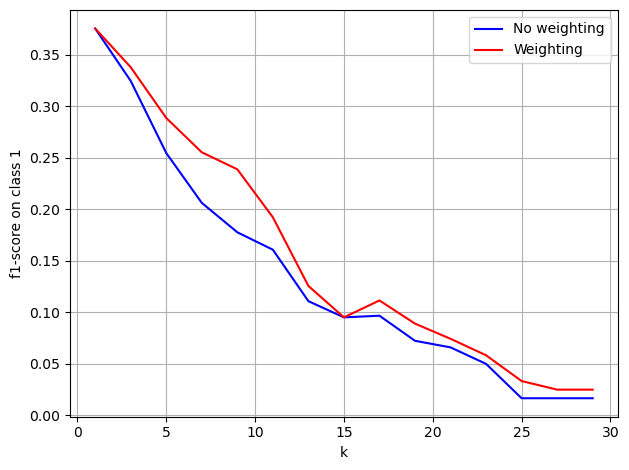

In [16]:
from sklearn.model_selection import cross_val_score  
import sklearn.neighbors as nb  
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

f_scorer = make_scorer(f1_score,pos_label=1)

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(n_neighbors = ki), 
        X = X_train, 
        y = y_train, 
        cv = 10, 
        scoring = f_scorer
    )
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(
            n_neighbors = ki,
            weights = "distance"
        ), 
        X = X_train, 
        y = y_train, 
        cv = 10, 
        scoring = f_scorer
    )
    lr.append(np.mean(cv_scores))

plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('f1-score on class 1')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

Best results are for k=1. Let's train the model on over-sampled data and apply to untouched test set and see results

In [17]:
# K=1
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

clf = nb.KNeighborsClassifier(n_neighbors = 1).fit(X_resampled, y_resampled)
y_pred_bal = clf.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print("Confusion matrix on test set:\n",confusion_matrix(y_test, y_pred_bal))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2230
           1       0.42      0.35      0.38       270

    accuracy                           0.88      2500
   macro avg       0.67      0.64      0.66      2500
weighted avg       0.87      0.88      0.87      2500

Confusion matrix on test set:
 [[2098  132]
 [ 176   94]]


In this cell we do cross-validation on oversampled training data to find best parameters (but we don't care about what happens inside each cross-validation)

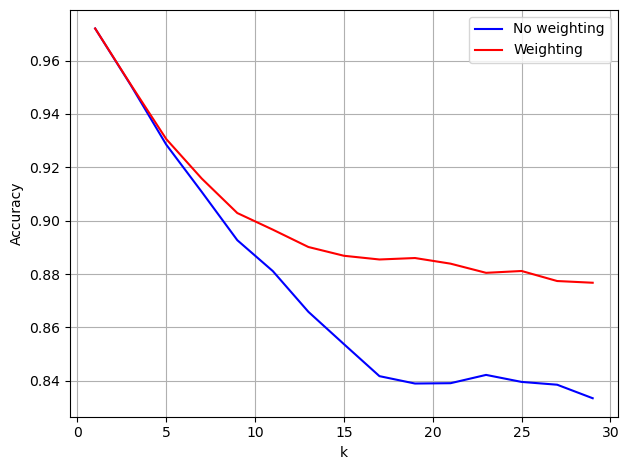

In [23]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(n_neighbors = ki), 
        X = X_resampled, 
        y = y_resampled, 
        cv = 10, 
        scoring = f_scorer
    )
    lr.append(np.mean(cv_scores))
    
plt.plot(
    range(1,30,2),
    lr,
    "blue",
    label = "No weighting"
)

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(n_neighbors = ki, weights = "distance"),
        X = X_resampled, 
        y = y_resampled, 
        cv = 10, 
        scoring = f_scorer
    )
    lr.append(np.mean(cv_scores))
    
plt.plot(
    range(1,30,2),
    lr,
    "red",
    label = "Weighting"
)
# Adding labels and other details to the graphic
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend(loc = "upper right")
plt.grid()
plt.tight_layout()
plt.show()

Best value for K=1... But don't you see something suspicious in the curve? Yes, too high! 

In [19]:
# K=1

clf = nb.KNeighborsClassifier(n_neighbors = 1).fit(X_resampled, y_resampled)
y_pred_bal = clf.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print("Confusion matrix on test set:\n",confusion_matrix(y_test, y_pred_bal))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2230
           1       0.42      0.35      0.38       270

    accuracy                           0.88      2500
   macro avg       0.67      0.64      0.66      2500
weighted avg       0.87      0.88      0.87      2500

Confusion matrix on test set:
 [[2098  132]
 [ 176   94]]


Ooops. Nothing changed with respect to original one. Yes, because test at each cross-validation was also OVERSAMPLED... This explains the high values of the previous figure.

**Lets do things as they should be done!**

In [37]:
### Example of function that returns K-folds OVER-sampled. Should be done the same
def K_foldCross_val_OVER(X_train, y_train, k = 10, random_seed = 0):
    """Creation of the Oversampled k sets where training is oversampled and test not."""
    
    kf = StratifiedKFold(
        n_splits = k, 
        random_state = random_seed, 
        shuffle = True
    )
    l_X_train=[]
    l_y_train=[]
    l_X_test=[]
    l_y_test=[]

    for train_index_ls, validation_index_ls in kf.split(X_train, y_train):
        # keeping validation set apart and oversampling in each iteration using smote 
        train, validation = X_train[train_index_ls], X_train[validation_index_ls]
        target_train, target_val = y_train[train_index_ls], y_train[validation_index_ls]
        ros = RandomOverSampler(random_state = random_seed)  ##Thing to change!
        X_resampled, y_resampled = ros.fit_resample(train, target_train)

        l_X_train.append(X_resampled)
        l_y_train.append(y_resampled)
        l_X_test.append(validation)
        l_y_test.append(target_val)  
    
    return l_X_train,l_y_train,l_X_test,l_y_test


def cross_val_unb(clf, X_train, y_train, method = K_foldCross_val_OVER, score = f1_score, pos_label = 1):
    scores = []
    l_X_train,l_y_train,l_X_test,l_y_test = method(X_train,y_train)
    for i in range(len(l_X_train)):
        validation_preds =  clf.fit(l_X_train[i], l_y_train[i]).predict(l_X_test[i])
        scores.append(score(l_y_test[i], validation_preds,pos_label=pos_label))

    return scores

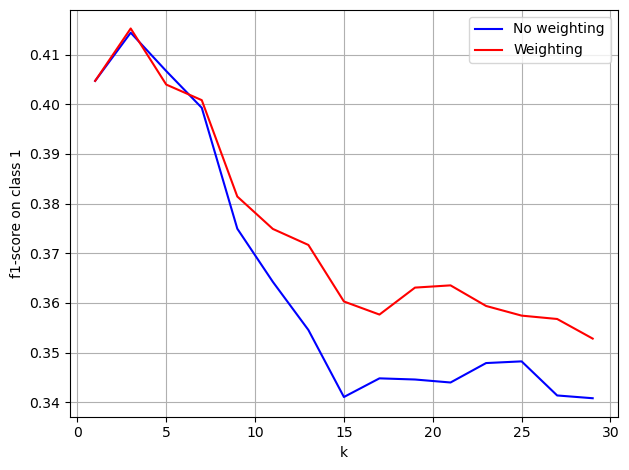

In [24]:
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_unb(
        nb.KNeighborsClassifier(n_neighbors = ki), 
        X_train, 
        y_train, 
        score = f1_score, 
        pos_label = 1
    )
    lr.append(np.mean(cv_scores))
plt.plot(
    range(1, 30, 2),
    lr,
    "blue",
    label = "No weighting"
)

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_unb(
        nb.KNeighborsClassifier(n_neighbors = ki, weights = "distance"), 
        X_train, 
        y_train, 
        score = f1_score, 
        pos_label = 1
    )
    lr.append(np.mean(cv_scores))
    
plt.plot(
    range(1,30,2),
    lr,
    "red",
    label = "Weighting"
)
# Adding labels and other details to the graphic
plt.xlabel("k")
plt.ylabel("f1-score on class 1")
plt.legend(loc = "upper right")
plt.grid()
plt.tight_layout()
plt.show()

In [36]:
# K=3

ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

clf = nb.KNeighborsClassifier(n_neighbors = 3).fit(X_resampled, y_resampled)
y_pred_bal = clf.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2230
           1       0.36      0.51      0.42       270

    accuracy                           0.85      2500
   macro avg       0.65      0.70      0.67      2500
weighted avg       0.88      0.85      0.86      2500

Confusion matrix on test set:
[[1988  242]
 [ 132  138]]


Best results so far.

### Other techniques with sampling data: Undersampling and SMOTE

This is an example for Naive Bayes that does not need adjusting parameters. In case you use KNN you have to adapt the previous caveat to the technique applied.

In [35]:
# Solution doing undersampling of the larger class. There are several method implemented. 
# I recommend any of the following ones:
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    InstanceHardnessThreshold,
)

pipeline = pl.make_pipeline(
    RandomUnderSampler(random_state = RANDOM_STATE), 
    GaussianNB()
)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print("\n** Results for UNDERSAMPLING with method Random")
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")

pipeline = pl.make_pipeline(
    InstanceHardnessThreshold(random_state = RANDOM_STATE), 
    GaussianNB()
)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print("\n** Results for UNDERSAMPLING with method Instance Hardness threshold")
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")
    
pipeline = pl.make_pipeline(
    CondensedNearestNeighbour(random_state = RANDOM_STATE),
    GaussianNB()
)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print("\n** Results for UNDERSAMPLING with method Condensed Nearest Neighbour")
print(classification_report(y_test, y_pred_bal))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")


** Results for UNDERSAMPLING with method Random
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      2230
           1       0.27      0.89      0.42       270

    accuracy                           0.73      2500
   macro avg       0.63      0.80      0.62      2500
weighted avg       0.91      0.73      0.78      2500

Confusion matrix on test set:
[[1592  638]
 [  30  240]]

** Results for UNDERSAMPLING with method Instance Hardness threshold
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2230
           1       0.52      0.49      0.50       270

    accuracy                           0.90      2500
   macro avg       0.73      0.72      0.72      2500
weighted avg       0.89      0.90      0.89      2500

Confusion matrix on test set:
[[2107  123]
 [ 139  131]]

** Results for UNDERSAMPLING with method Condensed Nearest Neighbour
              precision    recall  f1-score

In [34]:
# Solution creating artificial examples of the smaller class
from imblearn import over_sampling as os

pipeline = pl.make_pipeline(
    os.SMOTE(random_state = RANDOM_STATE), 
    GaussianNB()
)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print(f"\n Confusion matrix on test set:\n{confusion_matrix(y_test, y_pred_bal)}")

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      2230
           1       0.27      0.83      0.41       270

    accuracy                           0.74      2500
   macro avg       0.62      0.78      0.62      2500
weighted avg       0.90      0.74      0.79      2500


 Confusion matrix on test set:
[[1630  600]
 [  46  224]]


## Final notes
There are some algorithm, for instance SVM, where you can introduce the weigth of each class in the calssification class. See the following example:

In [33]:
## This technique gives more importance to one class than to another, so we can pay more attention to the 
## smaller class.

## It can be applied to DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier and SVM
## but not to NaiveBayes neither KNN where other techniques should be applied
## This technique can be applier indirectly to AdaBoostClassifier, BaggingClassifier if the base classifiers are 
## DecisionTrees for wich we define the "class_weight"

# Example for SVM
import matplotlib.pyplot as plt
from sklearn import svm

Cs = np.logspace(-2, 2, num = 5, base = 10.0)
print("Tested Cs", Cs)
param_grid = {'C': Cs}

# fit the model and get the separating hyperplane
grid_search = GridSearchCV(
    svm.SVC(kernel = "rbf"), 
    param_grid, 
    cv = 10
)
grid_search.fit(X_train, y_train)
parval = grid_search.best_params_
print(f"Best C = {parval['C']}")

clf = svm.SVC(
    kernel = "rbf",
    C = parval["C"]
)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print("\n** Results for Plain SVM")
print(classification_report(y_test, pred))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, pred)}")
 
# fit the model and get the separating hyperplane using weighted classes
grid_search = GridSearchCV(
    svm.SVC(
        kernel = "rbf", 
        class_weight = {1: 10}
    ), 
    param_grid, 
    cv = 10
)
grid_search.fit(X_train, y_train)
parval = grid_search.best_params_
print(f"Best C = {parval['C']}")

clf = svm.SVC(
    kernel = "rbf",
    C = parval['C'], 
    class_weight={1: 10}
)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print("\n** Results for Plain SVM with ratio for class 1 set to 10")
print(classification_report(y_test, pred))
print(f"Confusion matrix on test set:\n{confusion_matrix(y_test, pred)}") 

Tested Cs [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
Best C =10.0

** Results for Plain SVM
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2230
           1       0.82      0.23      0.36       270

    accuracy                           0.91      2500
   macro avg       0.86      0.61      0.66      2500
weighted avg       0.90      0.91      0.89      2500

Confusion matrix on test set:
[[2216   14]
 [ 208   62]]
Best C = 100.0

** Results for Plain SVM with ratio for class 1 set to 10
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      2230
           1       0.33      0.67      0.44       270

    accuracy                           0.82      2500
   macro avg       0.64      0.75      0.66      2500
weighted avg       0.89      0.82      0.84      2500

Confusion matrix on test set:
[[1861  369]
 [  90  180]]


Results with SVM are not very good because we haven't adjusted the gamma parameter, only C parameter is adjusted....  but the idea is there.